In [ ]:
pip install tensorflow

In [ ]:
pip install opencv-contrib-python

In [ ]:
pip install matplotlib

In [ ]:
pip install numpy

### Folders Name inside train dataset

- 0 - Angry
- 1 - Disgust
- 2 - Fear
- 3 - Happy
- 4 - Sad
- 5 - Surprise
- 6 - Neutral"

In [ ]:
pip install pandas

In [1]:
import tensorflow as tf
tf.keras.backend.clear_session()


2024-12-13 21:28:29.791423: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734104609.837574   10971 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734104609.850831   10971 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-13 21:28:29.921557: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [1]:
import tensorflow as tf
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import os
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'


2024-12-14 21:41:38.303432: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734191798.368838   50047 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734191798.383531   50047 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-14 21:41:38.486341: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# Check if GPUs are available
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPUs are available: {[gpu.name for gpu in gpus]}")
else:
    print("No GPUs are available.")




Num GPUs Available:  1
GPUs are available: ['/physical_device:GPU:0']


In [4]:
df = pd.read_csv("fer2013.csv")

In [5]:
df.shape

(35887, 3)

- `35887` rows and `3` columns

In [6]:
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [7]:
df.emotion.unique()

array([0, 2, 4, 6, 3, 5, 1])

In [8]:
emotion_label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

In [9]:
df.emotion.value_counts()

emotion
3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: count, dtype: int64

In [10]:
# Calculate the width (and height) of the square image from the number of pixel values
# in the first row of the 'pixels' column. Assumes the image is square.

math.sqrt(len(df.pixels[0].split(' ')))

48.0

- `48 (Height)`: The number of pixels along the vertical axis (image height).
- `48 (Width)`: The number of pixels along the horizontal axis (image width).

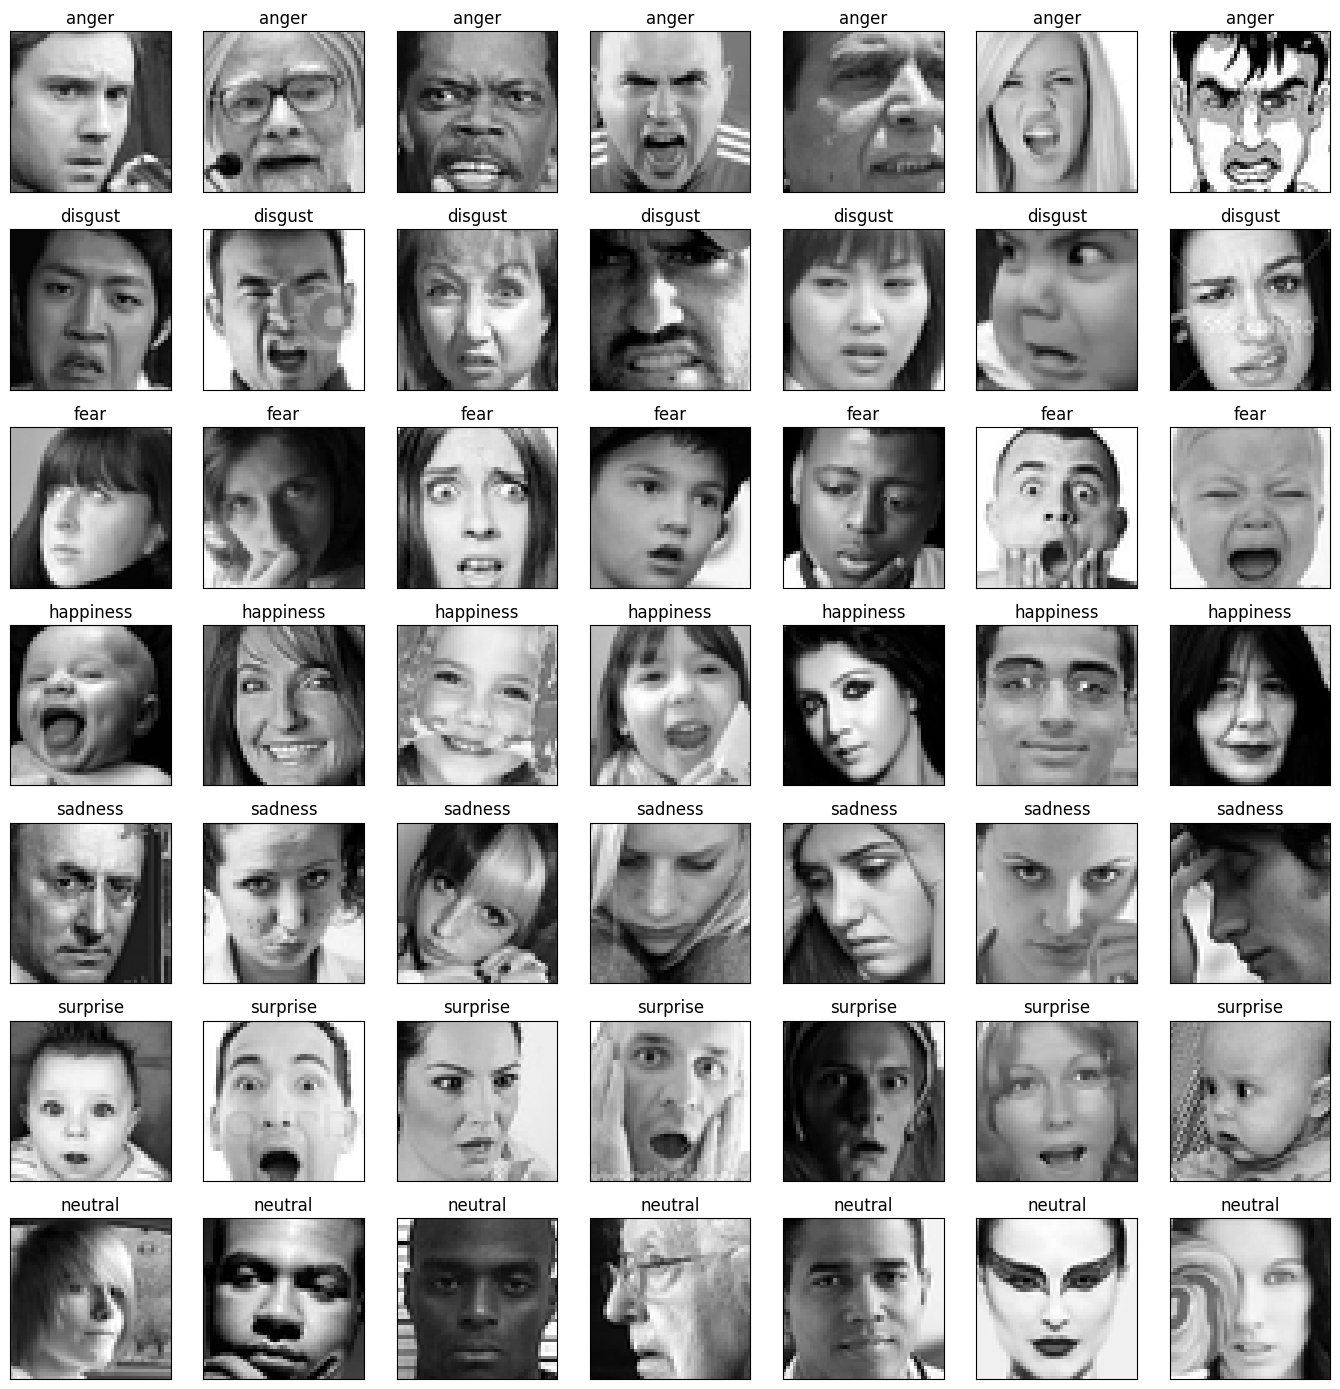

In [11]:
fig = plt.figure(1, (14, 14))

k = 0
for label in sorted(df.emotion.unique()):
    for j in range(7):
        px = df[df.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

        k += 1
        ax = plt.subplot(7, 7, k)
        ax.imshow(px, cmap = 'gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_label_to_text[label])
        plt.tight_layout()

## Converting Pixel into array

In [12]:
# Convert the 'pixels' column (space-separated pixel values) into a 3D NumPy array.
# Each row is reshaped into a 48x48 2D array of float32 type, and all images are stacked
# into a single 3D array with shape (n, 48, 48), where n is the number of rows.

img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48).astype('float32'))
img_array = np.stack(img_array, axis=0)


In [13]:
img_array.shape

(35887, 48, 48)

In [14]:
img_features = []

for i in range(len(img_array)):
    temp = cv2.cvtColor(img_array[i], cv2.COLOR_GRAY2RGB)
    img_features.append(temp)

img_features = np.array(img_features)
print(img_features.shape)

(35887, 48, 48, 3)


### Label Encoding the Emotions column

In [15]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

le = LabelEncoder()

img_labels = le.fit_transform(df.emotion)
img_labels = to_categorical(img_labels)
img_labels.shape

(35887, 7)

In [16]:

le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)


{np.int64(0): np.int64(0), np.int64(1): np.int64(1), np.int64(2): np.int64(2), np.int64(3): np.int64(3), np.int64(4): np.int64(4), np.int64(5): np.int64(5), np.int64(6): np.int64(6)}


## Splitting Dataset to training and testing set.

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(img_features, img_labels, shuffle = True, stratify = img_labels,
                                                      test_size = 0.2, random_state = 42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((28709, 48, 48, 3), (7178, 48, 48, 3), (28709, 7), (7178, 7))

## Normalization

In [18]:
X_train = X_train / 255.
X_test = X_test / 255.

In [19]:
print(f"Min pixel value: {X_train.min()}, Max pixel value: {X_train.max()}")


Min pixel value: 0.0, Max pixel value: 1.0


In [20]:
X_train.shape

(28709, 48, 48, 3)

In [21]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [22]:
X_train.shape

(28709, 48, 48, 3)

In [23]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

## Deep learning models for Training - Transfer Learning (VGG19)

In [24]:
vgg = tf.keras.applications.VGG19(weights = 'imagenet',
                                  include_top = False,
                                  input_shape = (48, 48, 3))


I0000 00:00:1734104756.229453   10971 gpu_process_state.cc:201] Using CUDA malloc Async allocator for GPU: 0
I0000 00:00:1734104756.229755   10971 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1971 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2050, pci bus id: 0000:01:00.0, compute capability: 8.6


This code makes all layers of a VGG19 model non-trainable. This allows the model to be applied to a new problem using only pre-learned features, rather than reflecting changes in the training data to the model, while preserving the pre-trained weights. This is a technique often used in transfer learning applications.

In particular, while developing a facial emotion recognition model using the VGG19 model, the pre-trained weights of the model are preserved, allowing it to be used in solving a new emotion recognition problem. In this way, it may be possible to obtain better results using less data.

In [25]:
vgg.summary()

Model: "vgg19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 48, 48, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 6, 6, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 1, 1, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 20,024,384 (76.39 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
from tensorflow.keras.layers import Input, Conv2D, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

def build_model(bottom_model, classes):
    model = bottom_model.layers[-2].output
    model = GlobalAveragePooling2D()(model)
    model = Dense(classes, activation = 'softmax', name = 'out_layer')(model)
    
    return model

In [27]:
head = build_model(vgg, num_classes)

model = Model(inputs = vgg.input, outputs = head)

print(model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 48, 48, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 6, 6, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ out_layer (Dense)               │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,027,975 (76.40 MB)

 Trainable params: 20,027,975 (76.40 MB)

 Non-trainable params: 0 (0.00 B)

None


In [28]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

early_stopping = EarlyStopping(monitor = 'val_accuracy', 
                               min_delta = 0.00005, 
                               patience = 11,
                               verbose = 1, 
                               restore_best_weights = True,)

lr_scheduler = ReduceLROnPlateau(monitor = 'val_accuracy', 
                                 factor = 0.5, 
                                 patience = 7,
                                 min_lr = 1e-7,
                                 verbose = 1,)

callbacks = [early_stopping,lr_scheduler,]

- I used two callbacks one is early stopping for avoiding overfitting training data and other ReduceLROnPlateau for learning rate.

In [29]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np


train_datagen = ImageDataGenerator(rotation_range = 15,
                                   width_shift_range = 0.15,
                                   height_shift_range = 0.15,
                                   shear_range = 0.15,
                                   zoom_range = 0.15,
                                   horizontal_flip = True,)
train_datagen.fit(X_train)

- As the data in hand is less as compared to the task so ImageDataGenerator is good to go.

###  Compiling the Model

In [30]:
# batch size of 32 performs the best.
from tensorflow.keras import optimizers

batch_size = 16
epochs = 25
optims = [optimizers.Adam(learning_rate = 0.0001, 
                          beta_1 = 0.9, beta_2 = 0.999),]

model.compile(loss = 'categorical_crossentropy',
              optimizer = optims[0],
              metrics = ['accuracy'])

### Training the Model

In [31]:
train_datagen = ImageDataGenerator(rotation_range = 15,
                                   width_shift_range = 0.15,
                                   height_shift_range = 0.15,
                                   shear_range = 0.15,
                                   zoom_range = 0.15,
                                   horizontal_flip = True,)
train_datagen.fit(X_train)

# batch size of 32 performs the best.
batch_size = 32 
epochs = 30
optims = [optimizers.Adam(learning_rate = 0.0001, 
                          beta_1 = 0.9, beta_2 = 0.999),]

model.compile(loss = 'categorical_crossentropy',
              optimizer = optims[0],
              metrics = ['accuracy'])

history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_test, y_test),
    steps_per_epoch=len(X_train) // batch_size,  # Corrected: Floor division
    epochs=epochs,
    callbacks=callbacks
)



Epoch 1/30


/home/namling/My_programs/Face and Emotion Recognition System (Project I)/myenv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1734104768.290401   11272 service.cc:148] XLA service 0x72310001bee0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734104768.290607   11272 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 2050, Compute Capability 8.6
2024-12-13 21:31:08.358129: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1734104768.716626   11272 cuda_dnn.cc:529] Loaded cuDNN versio

  1/897 ━━━━━━━━━━━━━━━━━━━━ 2:43:46 11s/step - accuracy: 0.3125 - loss: 1.9041

I0000 00:00:1734104776.479623   11272 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


897/897 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.3023 - loss: 1.7103

2024-12-13 21:33:36.584746: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 198457344 exceeds 10% of free system memory.
2024-12-13 21:33:36.762799: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 198457344 exceeds 10% of free system memory.


897/897 ━━━━━━━━━━━━━━━━━━━━ 159s 166ms/step - accuracy: 0.3024 - loss: 1.7101 - val_accuracy: 0.4802 - val_loss: 1.3119 - learning_rate: 1.0000e-04
Epoch 2/30
  1/897 ━━━━━━━━━━━━━━━━━━━━ 2:15 151ms/step - accuracy: 0.5312 - loss: 1.3613

/home/namling/My_programs/Face and Emotion Recognition System (Project I)/myenv/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


897/897 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.5312 - loss: 1.3613 - val_accuracy: 0.4805 - val_loss: 1.3111 - learning_rate: 1.0000e-04
Epoch 3/30
897/897 ━━━━━━━━━━━━━━━━━━━━ 137s 153ms/step - accuracy: 0.5012 - loss: 1.2953 - val_accuracy: 0.5446 - val_loss: 1.1879 - learning_rate: 1.0000e-04
Epoch 4/30
897/897 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.6875 - loss: 1.0695 - val_accuracy: 0.5415 - val_loss: 1.1981 - learning_rate: 1.0000e-04
Epoch 5/30
897/897 ━━━━━━━━━━━━━━━━━━━━ 137s 153ms/step - accuracy: 0.5377 - loss: 1.2110 - val_accuracy: 0.5326 - val_loss: 1.1983 - learning_rate: 1.0000e-04
Epoch 6/30
897/897 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.4375 - loss: 1.3682 - val_accuracy: 0.5329 - val_loss: 1.1965 - learning_rate: 1.0000e-04
Epoch 7/30
897/897 ━━━━━━━━━━━━━━━━━━━━ 137s 153ms/step - accuracy: 0.5728 - loss: 1.1374 - val_accuracy: 0.5982 - val_loss: 1.0566 - learning_rate: 1.0000e-04
Epoch 8/30
897/897 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy:

### Evaluating the model

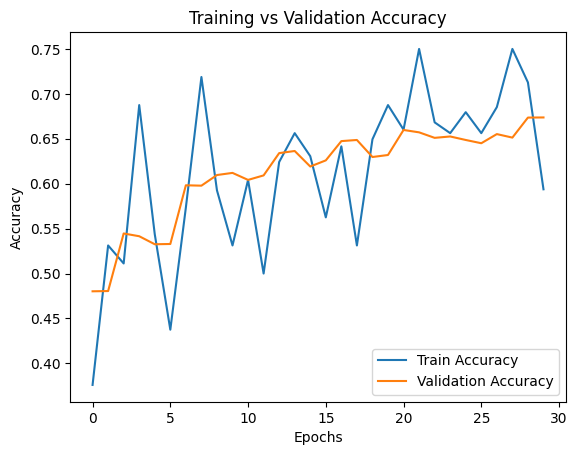

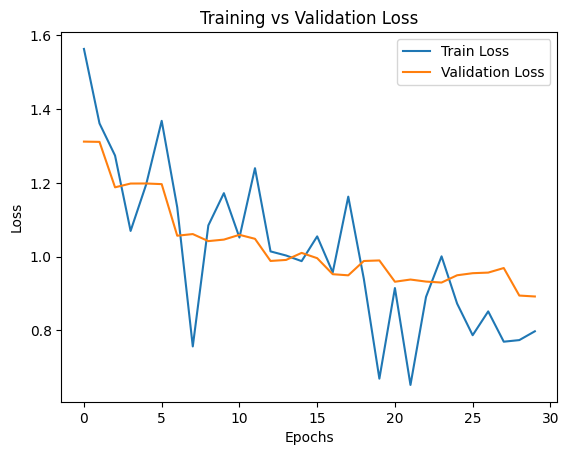

In [32]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.show()


In [33]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")


  3/225 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.7014 - loss: 0.8628 

2024-12-13 22:09:24.354082: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 198457344 exceeds 10% of free system memory.
2024-12-13 22:09:24.402024: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 198457344 exceeds 10% of free system memory.


225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.6750 - loss: 0.8761
Test Accuracy: 0.6737, Test Loss: 0.8917


## Saving model in keras file 

In [34]:
# Save the model after training
model.save('emotion_recognition_model_tf.keras')

## Loading saved model

In [2]:
model = tf.keras.models.load_model('emotion_recognition_model_tf.keras')

I0000 00:00:1734191816.357977   50047 gpu_process_state.cc:201] Using CUDA malloc Async allocator for GPU: 0
I0000 00:00:1734191816.358317   50047 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1601 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2050, pci bus id: 0000:01:00.0, compute capability: 8.6


## Testing with new image

In [3]:
frame = cv2.imread('sadboy.png')

In [4]:
frame.shape

(802, 629, 3)

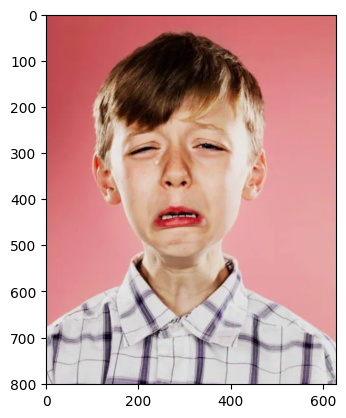

In [5]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

### Using haarcascade_frontalface_default.xml file for face detection.

In [6]:
faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

## Converting image color into gray

In [7]:
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

In [8]:
gray.shape

(802, 629)

In [9]:
faces = faceCascade.detectMultiScale(gray,1.1,4)
for x,y,w,h in faces : 
    roi_gray = gray[y:y+h, x: x+w]
    roi_color = frame[y:y+h, x: x+w]
    cv2.rectangle(frame, (x,y), (x+w, y+h), (255,0,0), 2) #BGR
    faces1 = faceCascade.detectMultiScale(roi_gray)
    if len(faces1) == 0:
        print("Faces not detected!!")
    else:
        for(ex,ey,ew,eh) in faces1:
            face_roi = roi_color[ey: ey+eh, ex: ex+ew]
        

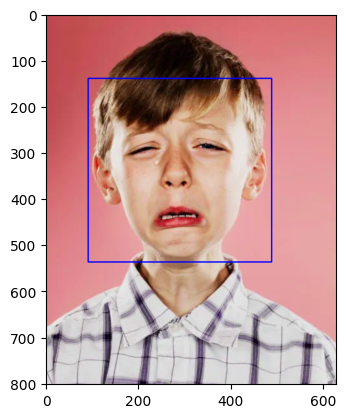

In [10]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

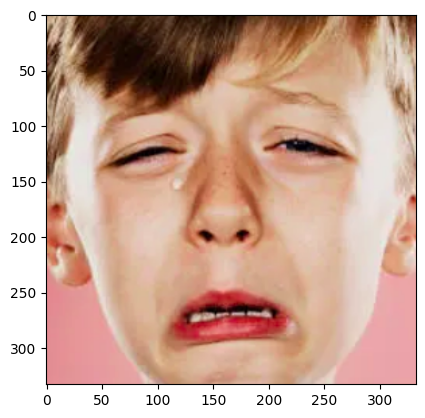

In [11]:
plt.imshow(cv2.cvtColor(face_roi, cv2.COLOR_BGR2RGB))

In [12]:
final_image = cv2.resize(face_roi,(48,48))
final_image = np.expand_dims(final_image, axis = 0) # need fourth dimension
final_image = final_image/255.0 # Normalizing

In [13]:
prediction = model.predict(final_image)

I0000 00:00:1734191840.212179   50181 service.cc:148] XLA service 0x73f358009f80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734191840.212214   50181 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 2050, Compute Capability 8.6
2024-12-14 21:42:20.224995: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1734191840.313229   50181 cuda_dnn.cc:529] Loaded cuDNN version 90300


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


2024-12-14 21:42:23.807391: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.4 which is older than the PTX compiler version 12.5.82. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
I0000 00:00:1734191843.949865   50181 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [14]:
prediction

array([[6.3380688e-02, 5.1502413e-03, 7.1826853e-02, 1.2044092e-03,
        8.4453684e-01, 7.0313492e-04, 1.3197789e-02]], dtype=float32)

In [15]:
np.argmax(prediction)

np.int64(4)

- 4 = sad